# Calculate RXE for public dataset, females only based on Apua's script

In [1]:
import re
import functools
import numpy as np
import pandas as pd
from os import environ
from plotnine import *
from scipy.stats import variation
from warnings import filterwarnings
from scipy.stats import mannwhitneyu
from matplotlib.cbook import mplDeprecation

In [2]:
filterwarnings("ignore",category=mplDeprecation)
filterwarnings('ignore', category=UserWarning, module='plotnine.*')
filterwarnings('ignore', category=DeprecationWarning, module='plotnine.*')

In [3]:
environ['NUMEXPR_MAX_THREADS'] = '10'

In [4]:
config = {
    'pheno_file': 'cmc_phenotypes.csv',
    'cpm_file': 'cmc_log2tpm.tsv',
    'tpm_file': '/ceph/users/jbenja13/projects/sex_sz_ria/input/commonMind/counts/gene_tpm/_m/log2tpm.csv',
    'annot_file': 'cmc_gene_annotation.tsv',
}

In [5]:
@functools.lru_cache()
def get_pheno():
    return pd.read_csv(config['pheno_file'], index_col=0)


@functools.lru_cache()
def get_annotation():
    return pd.read_csv(config['annot_file'], index_col=0, sep='\t')


In [6]:
def chrom_type(chrom):
    if chrom=='X':
        return 'X'
    elif re.search('^\d+', chrom):
        return 'autosome'
    else:
        return 'other'
    
    
def save_ggplot(p, fn):
    for ext in ['.pdf', '.png', '.svg']:
        p.save(fn+ext, width=10, height=7)


In [7]:
gene_annot = get_annotation()
gene_annot.head(2)

,ensembl_gene_id,hgnc_symbol,chromosome_name
gene_id,,,
ENSG00000000003.14,ENSG00000000003,TSPAN6,X
ENSG00000000005.5,ENSG00000000005,TNMD,X


In [8]:
gene_annot.shape

(57765, 3)

In [9]:
log2tpm = pd.read_csv(config['tpm_file'], index_col=0, sep=',', engine='c')
log2tpm.iloc[0:2, 0:5]

,MSSM_RNA_BP_PFC_2,MSSM_RNA_BP_PFC_4,MSSM_RNA_BP_PFC_5,MSSM_RNA_BP_PFC_6,MSSM_RNA_BP_PFC_7
gene_id,,,,,
ENSG00000000003.14,1.927755,1.341998,1.531728,1.565244,2.178456
ENSG00000000005.5,0.089456,0.036288,0.030684,0.088621,0.235076


In [10]:
log2tpm.shape

(50689, 606)

In [11]:
df0 = gene_annot.merge(log2tpm, right_index=True, left_index=True).drop_duplicates(subset=['ensembl_gene_id'])
df0.shape

(50097, 609)

In [12]:
df0['chrom_type'] = df0['chromosome_name'].apply(chrom_type)
df0.shape

(50097, 610)

In [13]:
df0.groupby('chrom_type').size()

chrom_type
X            1970
autosome    47618
other         509
dtype: int64

In [14]:
samples = np.array(log2tpm.columns[log2tpm.columns.str.contains("RNA|CMC", regex=True)])
df = df0[(df0[samples].sum(axis=1) >= 0.2 * len(samples)) & (df0['chrom_type'] != 'other')]
df1  = df.groupby('chrom_type').mean().transpose()
df1['sample'] = df1.index
df1['RXE'] = df1['X'] - df1['autosome']
df1.head(2)

chrom_type,X,autosome,sample,RXE
MSSM_RNA_BP_PFC_2,2.200941,2.124278,MSSM_RNA_BP_PFC_2,0.076663
MSSM_RNA_BP_PFC_4,1.666506,1.628365,MSSM_RNA_BP_PFC_4,0.038141


In [15]:
df2 = df1.merge(get_pheno(), left_index=True, right_index=True)
df2.head(2)

,X,autosome,sample,RXE,Individual_ID,Institution,Reported_Gender,Dx,Age_of_Death
MSSM_RNA_PFC_1,2.594985,2.529523,MSSM_RNA_PFC_1,0.065462,CMC_MSSM_025,MSSM,Male,SCZ,68.0
MSSM_RNA_PFC_2,2.672613,2.594684,MSSM_RNA_PFC_2,0.077929,CMC_MSSM_136,MSSM,Male,Control,76.0


In [16]:
df2.loc[:, ['Reported_Gender', 'Institution', 'RXE']].groupby(["Institution", 'Reported_Gender']).describe()

RXE                                          \
                             count      mean       std       min       25%   
Institution Reported_Gender                                                  
MSSM        Female           126.0  0.065413  0.067790 -0.090430  0.012126   
            Male             181.0  0.058109  0.061735 -0.122148  0.028566   
Penn        Female            54.0  0.089080  0.050252 -0.061299  0.057125   
            Male              40.0  0.087665  0.060816 -0.053713  0.051894   
Pitt        Female            41.0  0.097466  0.031784  0.035957  0.074324   
            Male             106.0  0.088188  0.038642  0.013731  0.061899   

                                                           
                                  50%       75%       max  
Institution Reported_Gender                                
MSSM        Female           0.077704  0.109618  0.255605  
            Male             0.071640  0.100297  0.192727  
Penn        Female           0.088885  0.118559  0.238989  
            Male             0.090865  0.115655  0.243992  
Pitt        Female           0.096307  0.126792  0.157051  
            Male             0.085425  0.115341  0.186669

In [17]:
for institution in df2.Institution.unique():
    for sex in ["Female", "Male"]:
        var = variation(df2[(df2['Institution']==institution) & 
                            (df2['Reported_Gender']==sex)].RXE)
        print("There is %.3f variation for %s in %s." % (var, sex, institution))

There is 1.032 variation for Female in MSSM.
There is 1.059 variation for Male in MSSM.
There is 0.559 variation for Female in Penn.
There is 0.685 variation for Male in Penn.
There is 0.322 variation for Female in Pitt.
There is 0.436 variation for Male in Pitt.


In [18]:
df2.loc[:, ['Reported_Gender', 'Institution', 'RXE']].groupby(['Reported_Gender']).describe()

RXE                                                    \
                 count      mean       std       min       25%       50%   
Reported_Gender                                                            
Female           221.0  0.077142  0.059949 -0.090430  0.047601  0.085898   
Male             327.0  0.071475  0.057008 -0.122148  0.044566  0.077639   

                                     
                      75%       max  
Reported_Gender                      
Female           0.113375  0.255605  
Male             0.106715  0.243992

In [19]:
for sex in ["Female", "Male"]:
    var = variation(df2[(df2['Reported_Gender']==sex)].RXE)
    print("There is %.3f variation for %s." % (var, sex)) # Not sure if this variation is real

There is 0.775 variation for Female.
There is 0.796 variation for Male.


### Separate out tissues

In [20]:
for institution in df2.Institution.unique():
    dft = df2[(df2['Institution'] == institution)].copy()
    stat, pval = mannwhitneyu(dft[(dft['Reported_Gender']=="Female")].RXE,
                              dft[(dft['Reported_Gender']=="Male")].RXE)
    print("Mann-WhitneyU for female vs male (RXE) for %s: %.4f" % (institution, pval))

Mann-WhitneyU for female vs male (RXE) for MSSM: 0.1548
Mann-WhitneyU for female vs male (RXE) for Penn: 0.4137
Mann-WhitneyU for female vs male (RXE) for Pitt: 0.0719


In [21]:
stat, pval = mannwhitneyu(df2[(df2['Reported_Gender']=="Female")].RXE,
                          df2[(df2['Reported_Gender']=="Male")].RXE)
print("Mann-WhitneyU for female vs male (RXE) for %s: %.4f, %.1f" % ("DLPFC", pval, stat))

Mann-WhitneyU for female vs male (RXE) for DLPFC: 0.0734, 33495.0


In [22]:
for institution in df2.Institution.unique():
    dft = df2[(df2['Institution'] == institution)].copy()
    stat, pval = mannwhitneyu(dft[(dft['Dx']=='Control')].RXE, 
                              dft[(dft['Dx']=='SCZ')].RXE)
    print("Mann-WhitneyU for ctl vs sz (RXE) for %s: %.4e" % (institution, pval))

Mann-WhitneyU for ctl vs sz (RXE) for MSSM: 1.6429e-02
Mann-WhitneyU for ctl vs sz (RXE) for Penn: 1.6475e-01
Mann-WhitneyU for ctl vs sz (RXE) for Pitt: 1.7510e-01


In [23]:
stat, pval = mannwhitneyu(df2[(df2['Dx']=="Control")].RXE,
                          df2[(df2['Dx']=="SCZ")].RXE)
print("Mann-WhitneyU for female vs male (RXE) for %s: %.4e, %.1f" % ("DLPFC", pval, stat))

Mann-WhitneyU for female vs male (RXE) for DLPFC: 3.1883e-02, 33911.0


In [24]:
for institution in df2.Institution.unique():
    dft = df2[(df2['Institution'] == institution)].copy()
    female = dft[(dft['Reported_Gender']=='Female')].copy()
    male = dft[(dft['Reported_Gender']=='Male')].copy()
    stat_f, pval_f = mannwhitneyu(female[(female['Dx']=='Control')].RXE, 
                                  female[(female['Dx']=='SCZ')].RXE)
    stat_m, pval_m = mannwhitneyu(male[(male['Dx']=='Control')].RXE, 
                                  male[(male['Dx']=='SCZ')].RXE)
    print("Mann-WhitneyU of female, ctl vs sz (RXE) for %s: %.4f" % (institution, pval_f))
    print("Mann-WhitneyU of male, ctl vs sz (RXE) for %s: %.4f" % (institution, pval_m))

Mann-WhitneyU of female, ctl vs sz (RXE) for MSSM: 0.1330
Mann-WhitneyU of male, ctl vs sz (RXE) for MSSM: 0.0499
Mann-WhitneyU of female, ctl vs sz (RXE) for Penn: 0.3124
Mann-WhitneyU of male, ctl vs sz (RXE) for Penn: 0.0294
Mann-WhitneyU of female, ctl vs sz (RXE) for Pitt: 0.3120
Mann-WhitneyU of male, ctl vs sz (RXE) for Pitt: 0.1254


In [25]:
female = df2[(df2['Reported_Gender']=='Female')].copy()
male = df2[(df2['Reported_Gender']=='Male')].copy()
stat_f, pval_f = mannwhitneyu(female[(female['Dx']=='Control')].RXE, 
                                  female[(female['Dx']=='SCZ')].RXE)
stat_m, pval_m = mannwhitneyu(male[(male['Dx']=='Control')].RXE, 
                                  male[(male['Dx']=='SCZ')].RXE)
print("Mann-WhitneyU of female, ctl vs sz (RXE) for %s: %.4f, %.2f" % ("DLPFC", pval_f, stat_f))
print("Mann-WhitneyU of male, ctl vs sz (RXE) for %s: %.4f, %.2f" % ("DLPFC", pval_m, stat_m))

Mann-WhitneyU of female, ctl vs sz (RXE) for DLPFC: 0.2171, 5601.00
Mann-WhitneyU of male, ctl vs sz (RXE) for DLPFC: 0.0487, 11943.00


### Interaction model

In [26]:
df2.Reported_Gender = df2.Reported_Gender.astype("category").cat.reorder_categories(["Female", "Male"], ordered=True)
df2.Dx = df2.Dx.astype("category").cat.rename_categories({"SCZ": "SZ", "Control": "CTL"})
df2.head(2)

,X,autosome,sample,RXE,Individual_ID,Institution,Reported_Gender,Dx,Age_of_Death
MSSM_RNA_PFC_1,2.594985,2.529523,MSSM_RNA_PFC_1,0.065462,CMC_MSSM_025,MSSM,Male,SZ,68.0
MSSM_RNA_PFC_2,2.672613,2.594684,MSSM_RNA_PFC_2,0.077929,CMC_MSSM_136,MSSM,Male,CTL,76.0


In [27]:
df3 = df2.loc[:, ['RXE', 'Reported_Gender', "Dx", 'Institution']]
df3.loc[:, "Reported_Gender"] = df3.Reported_Gender.cat.codes
df3.Dx = df3.Dx.cat.codes
df3.loc[:, "Institution"] = df3.Institution.astype("category").cat.codes
df3.head(2)

,RXE,Reported_Gender,Dx,Institution
MSSM_RNA_PFC_1,0.065462,1,1,0
MSSM_RNA_PFC_2,0.077929,1,0,0


In [28]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

anova_df = df2.loc[:,['RXE','Reported_Gender', "Dx", 'Institution']]

# ANOVA results with combinations of 2 groups:
formula = 'RXE ~ C(Reported_Gender) + C(Dx) + C(Institution) + C(Reported_Gender):C(Dx) + C(Reported_Gender):C(Institution) + C(Dx):C(Institution)'
lm = ols(formula, anova_df).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                                     sum_sq     df          F        PR(>F)
C(Reported_Gender)                 0.002992    1.0   0.938861  3.330063e-01
C(Dx)                              0.008155    1.0   2.559338  1.102315e-01
C(Institution)                     0.111778    2.0  17.540066  4.173517e-08
C(Reported_Gender):C(Dx)           0.000445    1.0   0.139511  7.089152e-01
C(Reported_Gender):C(Institution)  0.000732    2.0   0.114794  8.915716e-01
C(Dx):C(Institution)               0.013260    2.0   2.080725  1.258432e-01
Residual                           1.714256  538.0        NaN           NaN


#### There is a massive difference between institutions, but no interaction between institution and sex or sex and diagnosis

### Plot RXE

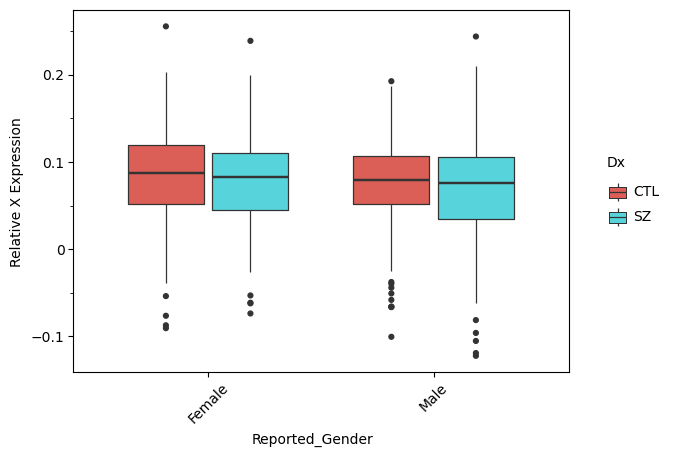

<ggplot: (8781457543801)>

In [29]:
p = ggplot(df2, aes(x='Reported_Gender', y='RXE', fill='Dx')) \
+ geom_boxplot()\
+ ylab("Relative X Expression")\
+ theme_matplotlib()
p + theme(axis_text_x = element_text(angle = 45))

/home/jbenja13/.local/lib/python3.9/site-packages/plotnine/facets/facet_grid.py:136: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/home/jbenja13/.local/lib/python3.9/site-packages/plotnine/facets/facet_grid.py:137: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead


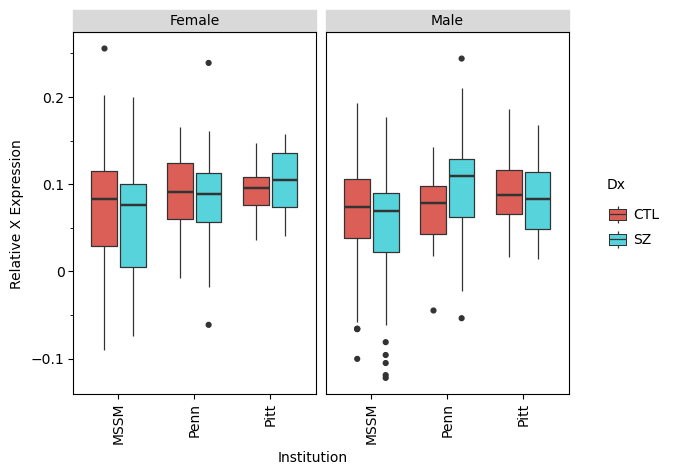

<ggplot: (8781457543774)>

In [30]:
p = ggplot(df2, aes(x='Institution', y='RXE', fill='Dx')) \
+ geom_boxplot()\
+ ylab("Relative X Expression")\
+ facet_grid("~Reported_Gender")\
+ theme_matplotlib()
p + theme(axis_text_x = element_text(angle = 90))

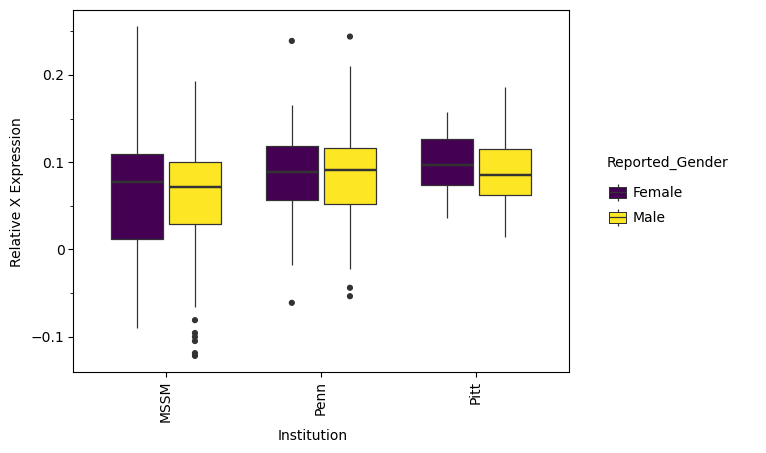

<ggplot: (8781458928014)>

In [31]:
p = ggplot(df2, aes(x='Institution', y='RXE', fill='Reported_Gender')) \
+ geom_boxplot()\
+ ylab("Relative X Expression")\
+ theme_matplotlib()
p + theme(axis_text_x = element_text(angle = 90))

/home/jbenja13/.local/lib/python3.9/site-packages/plotnine/facets/facet_grid.py:136: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/home/jbenja13/.local/lib/python3.9/site-packages/plotnine/facets/facet_grid.py:137: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead


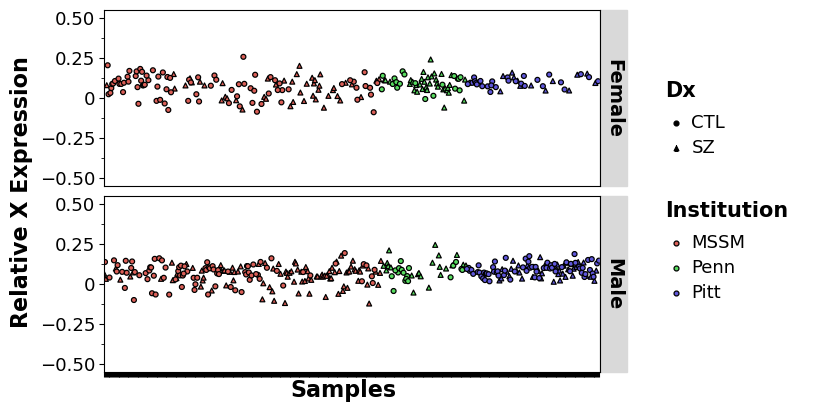

<ggplot: (8781458553733)>

In [32]:
p = ggplot(df2, aes(x='sample', y='RXE', shape="Dx", fill='Institution')) \
+ geom_point() + ylim([-0.5, 0.5]) + xlab("Samples")\
+ ylab("Relative X Expression") + facet_grid("Reported_Gender~.")\
+ theme_matplotlib() \
+ theme(axis_text_x=element_blank(), 
        axis_text=element_text(size=13), 
        legend_title=element_text(size=15, face="bold"), 
        legend_text=element_text(size=13),
        axis_title=element_text(size=16, face="bold"), 
        strip_text=element_text(size=14, face="bold"))
p

In [33]:
df2.to_csv('RXE_public.csv')
save_ggplot(p, "RXE_public_bySex")

/home/jbenja13/.local/lib/python3.9/site-packages/plotnine/facets/facet_grid.py:136: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/home/jbenja13/.local/lib/python3.9/site-packages/plotnine/facets/facet_grid.py:137: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/home/jbenja13/.local/lib/python3.9/site-packages/plotnine/facets/facet_grid.py:136: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/home/jbenja13/.local/lib/python3.9/site-packages/plotnine/facets/facet_grid.py:137: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logica